In [126]:
import os
import numpy as np
import pandas as pd
import numpy.linalg as npla
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

%matplotlib inline

# Project - Indian Liver Patient Dataset (ILPD)

The Indian Liver Patient Dataset has been downloaded from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/datasets/ILPD+%28Indian+Liver+Patient+Dataset%29). The dataset consists of 583 instances, 10 attributes and no missing values. There are 416 liver patient records and 167 non-liver patient records, which have been labeled by experts.

This project is being completed as part of the DSCI 573 Feature and Model Selection course at the University of British Columbia for the Master of Data Science Program.

In [135]:
#load in the data frame
data = pd.DataFrame(pd.read_csv("data/ilpd.csv", sep= ","))

#check for null values
data.isnull().sum()

#drop null
data = data.dropna(axis=0)

# no missing values!
data.isnull().sum()


Age          0
Gender       0
TB           0
DB           0
Alkphos      0
Sgpt         0
Sgot         0
TP           0
ALB          0
A/G Ratio    0
Selector     0
dtype: int64

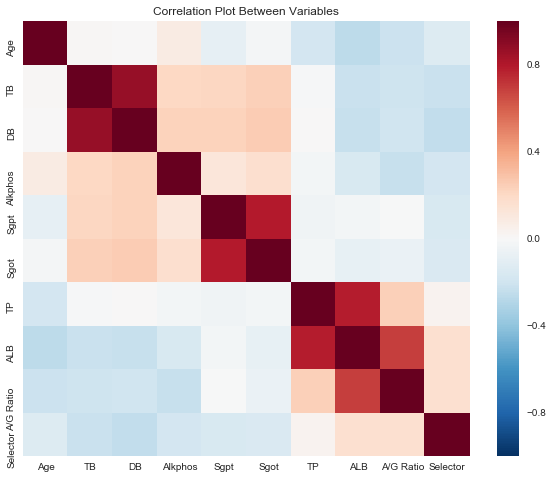

In [111]:
# Next, we'll plot a heatmap to visualize some relationships
plt.figure(figsize = (10,8))
sns.heatmap(data.corr())
plt.title("Correlation Plot Between Variables")

In [112]:
# Let us convert gender to numeric binary values

data["Gender"] = pd.Series(np.where(data.Gender == 'Female', 1, 0), data.index)

# Source: https://stackoverflow.com/questions/40901770/is-there-a-simple-way-to-change-a-column-of-yes-no-to-1-0-in-a-pandas-dataframe

In [113]:
# Create the target and features matrices

X = np.array(data.iloc[:,0:10])
Y = np.array(data["Selector"])

print("The dimensions of the original data are", data.shape)
print("The dimensions of the feature matrix are", X.shape)
print("The dimensions of the target matrix are", Y.shape)

#split the data into training and test data, then split the training data again to training and validation
Xtrain, Xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.30, random_state=100)

Xtrain, Xvalidate, ytrain, yvalidate = train_test_split(Xtrain, ytrain, test_size=0.30, random_state=100)


The dimensions of the original data are (579, 11)
The dimensions of the feature matrix are (579, 10)
The dimensions of the target matrix are (579,)


In [114]:
def fit_and_report(model, X, y, Xv, yv):
    """
    A function that fits a model and returns the MSE of the training and validation data.
    """
    model.fit(X,y)
    mean_squared_err = lambda y, yhat: np.mean((y-yhat)**2)
    errors = [mean_squared_err(y, model.predict(X)), mean_squared_err(yv, model.predict(Xv))]
    return errors

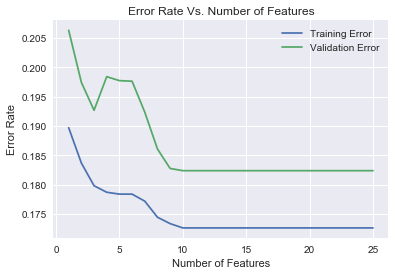

In [115]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import Ridge

# Next, we will look at the number of features and how they impact training and validation error

feat = range(1,26)
train_error = []
test_error = []

for i in feat:
    rfe = RFE(estimator = Ridge(), n_features_to_select = i)
    rfe.fit(Xtrain, ytrain)
    Xtrain_sel = Xtrain[:, rfe.support_]
    Xvalidate_sel = Xvalidate[:, rfe.support_]
    errs = fit_and_report(LinearRegression(), Xtrain_sel, ytrain, Xvalidate_sel, yvalidate)
    train_error.append(errs[0])
    test_error.append(errs[1])

# plot errors against number of features
plt.plot(feat, train_error, label = "Training Error")
plt.plot(feat, test_error, label = "Validation Error")
plt.legend(loc = "best")
plt.xlabel('Number of Features')
plt.ylabel('Error Rate')
plt.title("Error Rate Vs. Number of Features")
plt.show()

> It appears that 10 features will provide us with the lowest training and validation error.

In [116]:
# We can also use GridSearchCV to search for the best parameters.

gamma_value = [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
c = np.arange(0.1, 10, 0.5)
para_grid = dict(gamma = gamma_value, C = c)
clf = SVC()
cv = GridSearchCV(clf, para_grid)
cv.fit(Xtrain, ytrain)
print(cv.best_params_)
print(cv.best_score_)

{'C': 0.59999999999999998, 'gamma': 0.001}
0.766784452297


In [117]:
# run on validation data

clf = SVC(C=0.6, gamma=0.001)
clf.fit(Xtrain, ytrain)
print("The training Error is",(1 - clf.score(Xtrain, ytrain)))
print("The validation Error is",(1 - clf.score(Xvalidate, yvalidate)))


The training Error is 0.226148409894
The validation Error is 0.27868852459


In [125]:
#Not using cross validation - decision tree classifier
train_accuracy_rate = []
test_accuracy_rate = []
depth = range(1,20)
for i in depth:
    clf = DecisionTreeClassifier(random_state=100, max_depth=i)
    clf.fit(Xtrain, ytrain)
    train_accuracy_rate.append(1 - clf.score(Xtrain, ytrain))
    test_accuracy_rate.append(1 - clf.score(Xvalidate, yvalidate))
    

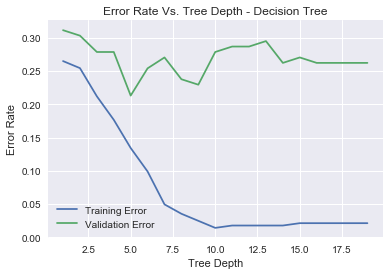

In [128]:
plt.plot(depth, train_accuracy_rate, label = "Training Error")
plt.plot(depth, test_accuracy_rate, label = "Validation Error")
plt.legend(loc = "best")
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')
plt.title("Error Rate Vs. Tree Depth - Decision Tree")
plt.show()

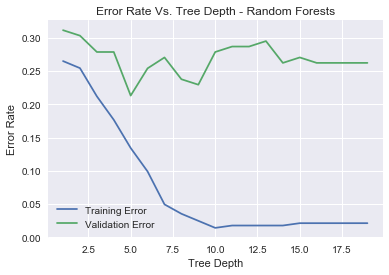

In [127]:
# Let us try to use Random Forests to get a lower validation error

train_accuracy_rate = []
test_accuracy_rate = []
depth = range(1,20)
for i in depth:
    clf = RandomForestClassifier(random_state=100, max_depth=i)
    clf.fit(Xtrain, ytrain)
    train_accuracy_rate.append(1 - clf.score(Xtrain, ytrain))
    test_accuracy_rate.append(1 - clf.score(Xvalidate, yvalidate))
    
plt.plot(depth, train_accuracy_rate, label = "Training Error")
plt.plot(depth, test_accuracy_rate, label = "Validation Error")
plt.legend(loc = "best")
plt.xlabel('Tree Depth')
plt.ylabel('Error Rate')
plt.title("Error Rate Vs. Tree Depth - Random Forests")
plt.show()

> From this graph, we see that a tree depth of 5 gives us the best validation set error at approximately 0.22.

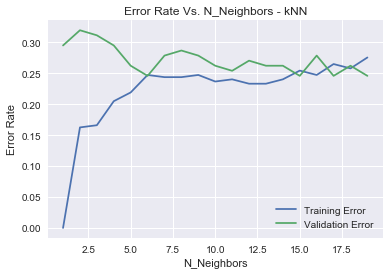

In [129]:
# Now we will try kNN

train_accuracy_rate = []
test_accuracy_rate = []
k = range(1,20)
for i in k:
    clf = KNeighborsClassifier(n_neighbors=i)
    clf.fit(Xtrain, ytrain)
    train_accuracy_rate.append(1 - clf.score(Xtrain, ytrain))
    test_accuracy_rate.append(1 - clf.score(Xvalidate, yvalidate))
    
plt.plot(depth, train_accuracy_rate, label = "Training Error")
plt.plot(depth, test_accuracy_rate, label = "Validation Error")
plt.legend(loc = "best")
plt.xlabel('N_Neighbors')
plt.ylabel('Error Rate')
plt.title("Error Rate Vs. N_Neighbors - kNN")
plt.show()

In [131]:
## Logistic Regression

clf = LogisticRegression(C=1, penalty="l2")
clf.fit(Xtrain, ytrain)
l2_error_train = 1 - clf.score(Xtrain, ytrain)
l2_error_val = 1 - clf.score(Xvalidate, yvalidate)
print("Training error:", l2_error_train)
print("Validation error:", l2_error_val)

Training error: 0.257950530035
Validation error: 0.27868852459


In [132]:
# For this project, we will use Random Forests for our test data

clf = RandomForestClassifier(random_state=100)
clf.fit(Xtrain, ytrain)
train_accuracy_rate = (1 - clf.score(Xtrain, ytrain))
test_accuracy_rate = (1 - clf.score(Xtest, ytest))

print("Training error:", train_accuracy_rate)
print("Test error:", test_accuracy_rate)

Training error: 0.0212014134276
Test error: 0.310344827586
